## Set up and libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import timeit
import time
from english_words import english_words_set
import benchit

## Our workhorse
Gaussian Kernel
$$
\begin{align}
    &kernel\_u:\mathbb{R}\to\mathbb{R}\\
    &kernel\_u(x)=\frac{1}{\sqrt{2\pi}}\exp\left[-\frac{1}{2}x^{2}\right]\\
    &kernel\_b:\mathbb{R}^{2}\to\mathbb{R}\\
    &kernel\_b(x,y)=\frac{1}{2\pi}\exp{\left[-\frac{1}{2}\left(x^{2}+y^{2}\right)\right]}
\end{align}
$$
Metric:
$$
\begin{align}
    &d:\mathcal{A}\times\mathcal{A}\to\mathbb{R}\\
    &d(V,W)=|A\triangle B|\text{ where }V,W\in \mathcal{A}\text{ are sets}\\
    &d\_vec:\mathcal{A}^{n}\times\mathcal{A}^{m}\to\mathbb{R}^{n}\times\mathbb{R}^{m}\\
    &d\_vec(\vec{V},\vec{W})=[|A_{i}\triangle B_{j}|]_{i,j}\text{ where }V_{i},W_{j}\in \mathcal{A}\text{ are the i-th and j-th coordinate of }\vec{A},\vec{B}\text{ respectively}
\end{align}
$$

In [2]:
def kernel_u(x):
    """
    univariate gaussian kernel
    
    Arguments:
    w :: float
    
    returns:
    float
    N(0,1)(w) mean zero unit variance normal distribution on w
    """
    return np.exp(-0.5*x**2)/np.sqrt(2*np.pi)
def kernel_b(x,y):
    """
    bivariate gaussian kernel
    
    Arguments:
    u,v :: float
    
    returns:
    float
    N(0,0,1,1,0)(u,v) bivariate standard normal distribution on (u,v)
    """
    return np.exp(-0.5*(x**2 + y**2))/(2*np.pi)
def d(V,W):
    """
    Metric function
    
    Arguments:
    x,y sets
    
    returns:
    float
    the Fréchet-Nikodyn distance between x and y
    """
    return len(V.symmetric_difference(W))
d_vec=np.vectorize(d)
"""
vectorized metric function d(X,Y)

Arguments
V,W sets or array of sets

returns:
array float
the distance between Vith and Wjth entries for all i and j
"""

'\nvectorized metric function d(X,Y)\n\nArguments\nV,W sets or array of sets\n\nreturns:\narray float\nthe distance between Vith and Wjth entries for all i and j\n'

## Ordered Sets 1.
### Manually sets
$A_{1}=\{\text{apple}\}$ is the minimal set.

$A_{12}=\{\text{apple, banana, pen, shark, tree, bird, fish, computer, home, house, chair, table}\}$ is the maximal set

In [3]:
array=[
    {"apple"},
    {"apple", "banana"},
    {"apple", "banana", "pen"},
    {"apple", "banana", "pen", "shark"},
    {"apple", "banana", "pen", "shark", "tree"},
    {"apple", "banana", "pen", "shark", "tree", "bird"},
    {"apple", "banana", "pen", "shark", "tree", "bird", "fish"},
    {"apple", "banana", "pen", "shark", "tree", "bird", "fish", "computer"},
    {"apple", "banana", "pen", "shark", "tree", "bird", "fish", "computer", "home"},
    {"apple", "banana", "pen", "shark", "tree", "bird", "fish", "computer", "home", "house"},
    {"apple", "banana", "pen", "shark", "tree", "bird", "fish", "computer", "home", "house", "chair"},
    {"apple", "banana", "pen", "shark", "tree", "bird", "fish", "computer", "home", "house", "chair", "table"},
]

Bandwidth matrix:
$
H=\begin{pmatrix}
h_{1} & 0 \\
0 & h_{2}
\end{pmatrix}
$

Python code: `H=[h1,h2]`

N-dimensional array of sets:

$
vert=\begin{pmatrix}
B_{1}\\
...\\
B_{i}\\
...\\
B_{n}
\end{pmatrix}
$ _*vertical*_ array

Python code: `vert=np.array(array).reshape(len(array),1)`

$
horz=\begin{pmatrix}
A_{1}&...&A_{i}&...&A_{n}
\end{pmatrix}
$ _*horizontal*_ array

Python code: `horz=np.array(array).reshape(1,len(array))`

Notice:

$$
\begin{pmatrix}
A_{1},&...&A_{i},&...&A_{n}
\end{pmatrix}\begin{pmatrix}
B_{1}\\
...\\
B_{i}\\
...\\
B_{n}
\end{pmatrix}=\vec{A}\cdot\vec{B}
$$

$$
d\_vec(A,\vec{B})=d\_vec(\vec{B},A)=\begin{pmatrix}
d(A,B_{1})\\
...\\
d(A,B_{i})\\
...\\
d(A,B_{n})
\end{pmatrix}
$$

$$
d\_vec(\vec{A},B)=d\_vec(B,\vec{A})=\begin{pmatrix}
d(A_{1},B),&...&d(A_{i},B),&...&d(A_{n},B)
\end{pmatrix}
$$

$$
d\_vec(array,array)=\begin{pmatrix}
d(array[1],array[1]),&...&d(array[i],array[i]),&...&d(array[n],array[n])
\end{pmatrix}=\vec{0}
$$

$$
d\_vec(\vec{B},\vec{A})=d\_vec(\vec{A},\vec{B})=\begin{pmatrix}
d(A_{1},B_{1}),&...&d(A_{1},B_{i}),&...&d(A_{1},B_{n})\\
...&...&...&...&...\\
d(A_{i},B_{1}),&...&d(A_{i},B_{i}),&...&d(A_{i},B_{n})\\
...&...&...&...&...\\
d(A_{n},B_{1}),&...&d(A_{n},B_{i}),&...&d(A_{n},B_{n})
\end{pmatrix}\text{ symmetric matrix}
$$

In [4]:
H=(100,100)
vert=np.array(array).reshape(len(array),1)
horz=np.array(array).reshape(1,len(array))

### Density function
$$
\begin{equation}
    f_\gamma(V_t, W_t) = \frac{1}{nh_{v}h_{w}}\sum\limits_{t}^{n}K\left(\frac{|V_t-V'_{t}|}{h_{v}}\right)K\left(\frac{|W_t-W'_{t}|}{h_{w}}\right)=\frac{1}{n\cdot det(H)}\sum\limits_{t}^{n}\mathbf{K}\left(H^{-1}(|V_{t}-V'_{t}|,|W_{t}-W'_{t}|)\right)
\end{equation}
$$

In [5]:
def a(X,Y=array[10]):
    """
    No optimized density function
    
    Arguments:
    X,Y (array) sets
    
    Returns:
    density function of X,Y
    (array) float
    """
    n=len(array)
    sum=0                       # sum to calculate density estimation
    for i in range(n):
        u = d(X,array[i])/H[0]  # compute the fisrt parameter to pass to bivariate kernel
        v = d(Y,array[i])/H[1]  # compute the second parameter to pass to bivariate kernel
        sum+=kernel_b(u,v)      # sum of kernel bivariate over all the ordered sets
    return sum/(n*H[0]*H[1])    # return the mean of kernel estimations times det of bandwitdh matrix
def density_est(V,W=array[10]):
    """
    Optimized density function
    
    Arguments:
    X,Y (array) sets
    
    Returns:
    density function of X,Y
    (array) float    
    """
    array1=kernel_u(d_vec(V,horz)/H[0]) #pass the fixed V,W to the whole array of ordered sets
    array2=kernel_u(d_vec(vert,W)/H[1])
    return np.dot(array1,array2)/(len(array)*H[0]*H[1]) # compute the sum using dot product

### Marginal distribution
$$
\begin{equation}
    Z(\mathcal{V},W_{t'})=\sum_{V_t\in\mathcal{V}}f_\gamma(V_t, W_{t'})
\end{equation}
$$

In [6]:
def b(X):
    """
    Not optimized marginal distribution
    
    Arguments:
    x set
    
    Returns:
    marginal distribution of X
    """
    sum=0                     # sum to calculate density estimator
    for element in array:
        sum+=a(element,X)     # sum the density function taking each set, fixed X
    return sum
def marginal_est(W):
    """
    Optimized marginal distribution
    
    Arguments:
    X set
    
    Return:
    marginal distribution of X
    """
    arr=density_est(vert,W)            #compute the array of the density estimations passing the whole array of sets to density_est
    return np.sum(arr)       # sum entry by entry

### Conditional Probability
$$
\begin{equation}\label{eq:jointmeasure}
    p(V_t|W_t)=\frac{f_\gamma(V_t, W_t)}{Z(\mathcal{V},W_t)}
\end{equation}
$$

In [7]:
def c(X,Y=array[10]):
    return a(X,Y)/b(Y)
def conditional_prob(X,Y=array[10]):
    return density_est(X,Y)/marginal_est(Y)

### Plotting
#### Density Estimations

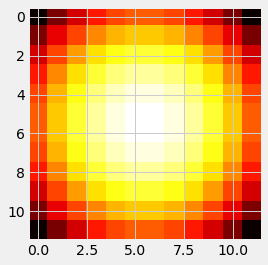

In [8]:
heatmap=np.zeros((len(array),len(array)))
for i in np.arange(len(array)):
    for j in np.arange(len(array)):
        heatmap[i,j]=a(array[i],array[j])
plt.imshow(heatmap, cmap='hot', interpolation='nearest')     

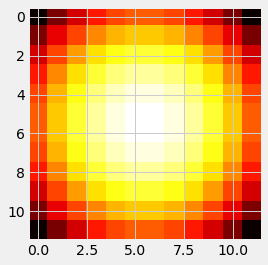

In [9]:
plt.imshow(density_est(vert,horz), cmap='hot', interpolation='nearest')

#### Marginal Estimations

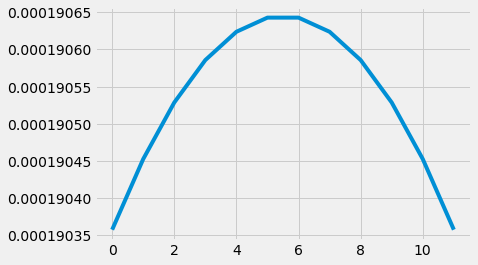

In [10]:
labels=np.arange(0,len(array))
plot1=np.zeros(len(array))
for i in np.arange(len(array)):
    plot1[i]=b(array[i])
plt.plot(labels, plot1)

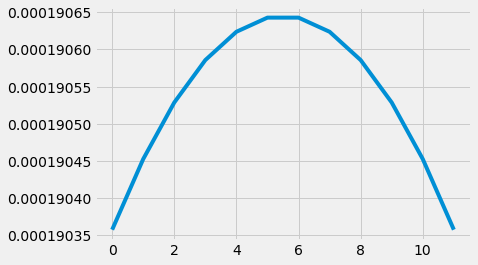

In [11]:
plot2=np.zeros(len(array))
for i in np.arange(len(array)):
    plot2[i]=marginal_est(array[i])
plt.plot(labels, plot2)

#### Probability distributions

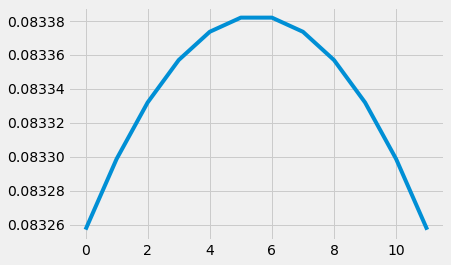

In [12]:
graf=np.zeros(len(array))
for i in range(len(array)):
    graf[i]=c(array[i],array[5])
plt.plot(labels, graf)

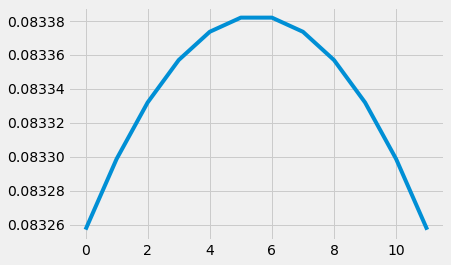

In [13]:
plt.plot(labels,conditional_prob(vert,array[5]))

## Ordered Sets 2.
Dealing with a largest sample

In [14]:
N=100
array=[set()]*N
i=0
for x in english_words_set:
    if i<N:
        if i==0:
            array[i]={x}
        else:
            array[i]=array[i-1].union({x})
    i=i+1
for i in np.arange(len(array)-1):
    if not array[i].issubset(array[i+1]):
        print("ERROR")
H=(100,100)
vert=np.array(array).reshape(N,1)
horz=np.array(array).reshape(1,N)

### Plotting
#### Density Estimations

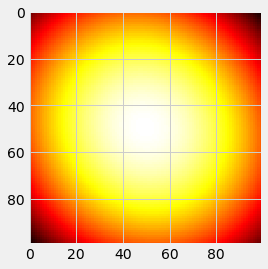

In [15]:
heatmap=np.zeros((len(array),len(array)))
for i in np.arange(len(array)):
    for j in np.arange(len(array)):
        heatmap[i,j]=a(array[i],array[j])
plt.imshow(heatmap, cmap='hot', interpolation='nearest')     

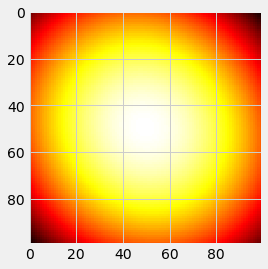

In [16]:
plt.imshow(density_est(vert,horz), cmap='hot', interpolation='nearest')

#### Marginal Estimations

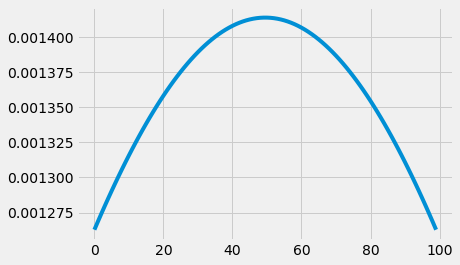

In [17]:
labels=np.arange(0,len(array))
output1=np.zeros(len(array))
for i in np.arange(len(array)):
    output1[i]=b(array[i])
plt.plot(labels, output1)

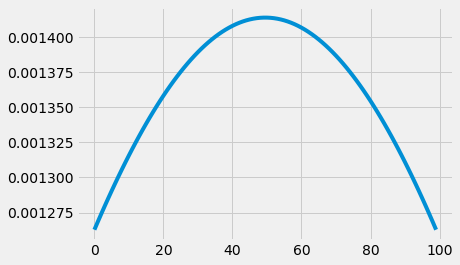

In [18]:
output2=np.zeros(len(array))
for i in np.arange(len(array)):
    output2[i]=marginal_est(array[i])
plt.plot(labels, output2)

#### Probability distributions

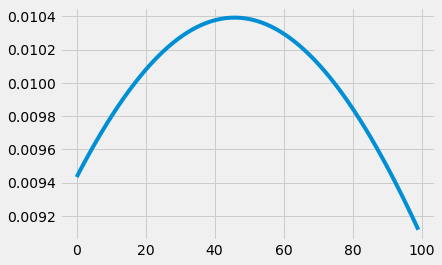

In [19]:
graf=np.zeros(len(array))
for i in range(len(array)):
    graf[i]=c(array[i],array[5])
plt.plot(labels, graf)

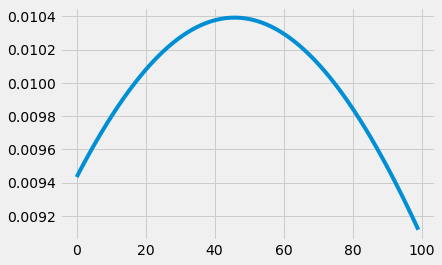

In [20]:
plt.plot(labels,conditional_prob(vert,array[5]))

## Benchmarks
Using timeit with some entries

In [21]:
for n in range(0,100,20):
    print("No optimized density estimation")
    %timeit a(array[n],array[10])
    print("Optimized density estimation")
    %timeit density_est(array[n],array[10])
    print("No optimized marginal estimation")
    %timeit b(array[n])
    print("Optimized marginal estimation")
    %timeit marginal_est(array[n])
    print("No optimized conditional probability")
    %timeit c(array[n],array[10])
    print("Optimized conditional probability")
    %timeit conditional_prob(array[n],array[10])
    print("==========================")

No optimized density estimation
228 µs ± 3.71 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Optimized density estimation
227 µs ± 5.32 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
No optimized marginal estimation
28.5 ms ± 275 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Optimized marginal estimation
11.7 ms ± 39.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
No optimized conditional probability
29.4 ms ± 282 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Optimized conditional probability
11.9 ms ± 30.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
No optimized density estimation
245 µs ± 1.67 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Optimized density estimation
257 µs ± 1.46 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
No optimized marginal estimation
30.5 ms ± 464 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Optimized marginal estimation
11.7 ms ± 77.1 µs per loop (mean ± 

### Plotting the runtime

In [ ]:
funcs = [a,b,c,density_est, marginal_est, conditional_prob]
inputs = {n: array[n] for n in range(N)}
t = benchit.timings(funcs, inputs, input_name='Number of elements in the set')

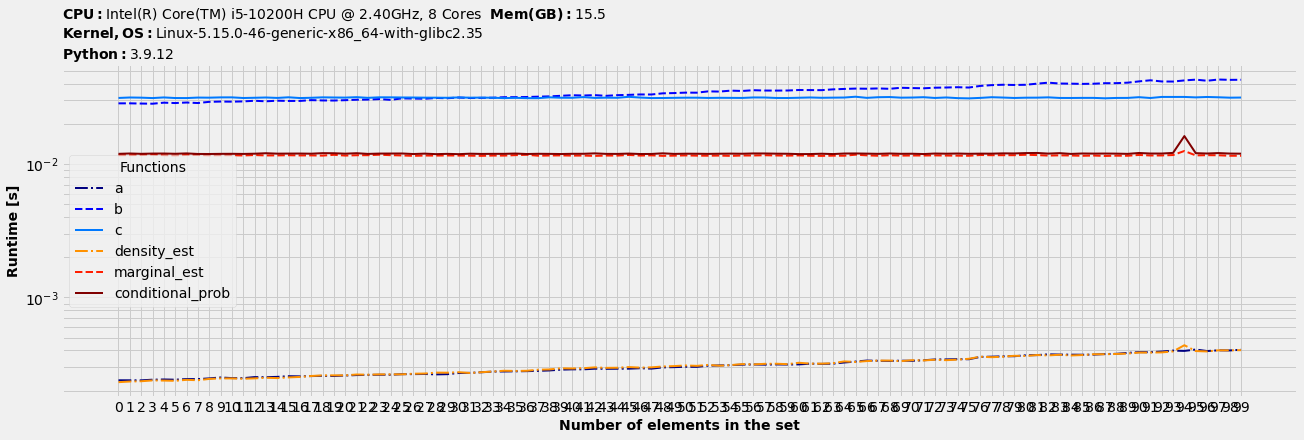

In [33]:
t.plot(logy=True,figsize=(18,6))